# Wrangling and Analyzing WeRateDogs Twitter Data
by Baily Jepsen

## Table of Contents
<ul>
    <li><a href="#gather">Gathering Data</a></li>
    <li><a href="#assess">Assessing Data</a></li>
    <li><a href="#clean">Cleaning Data</a></li>
    <li><a href="#store">Storing Data</a></li>
    <li><a href="#a/v">Analyzing and Visualizing Data</a></li>
</ul>

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy as tw
import numpy as np
import requests
import json
import os
from timeit import default_timer as timer

<a id='gather'></a>
## Gathering Data

In the cells below, I  gather all three sets of data for this project and load them in the notebook.

1. Directly download the WeRateDogs Twitter archive data.

In [2]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction.

In [3]:
# Set the URL
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# Send a HTTP request to the Udacity server and download the file 
# programatically
r = requests.get(url)

# Split the URL, open the file in write/binary (wb) mode, and write to the file
with open(os.path.join(url.split('/')[-1]), mode='wb') as file:
    file.write(r.content)

predictions_df = pd.read_csv('image-predictions.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API.

> **NOTE:**
The following section of code is for review purpose only. Using the Twitter API did not work no matter how I tried to go about it. I kept getting an error message stating that I need a higher access level, and I found that I do not meet the requirements for the academic access level. 

> I finally decided to copy & paste the provided code in the "Additional Resource: Twitter API" section, but it also did not work. I acknowledge that I do understand what the code is attempting to do, which is writing tweet data to the tweet_json.txt file VIA the Tweepy API and storing the IDs of the tweets that throw an error in a python dictionary. 

In [ ]:
# Set Twitter keys
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

# Create an API object that will be used to gather the Twitter data
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# Automatically wait for rate limits to replenish and print a notification
# when Tweepy is waiting for rate limits to replenish
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

print('Beginning Tweet Query')

count = 0
missing_tweets = {}
start = timer()

# Query the tweet IDs in the WeRateDogs Twitter archive
tweet_ids = archive_df.tweet_id.values

# Write the JSON data for each tweet ID to the tweet_json.txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate 
    # limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tw.TweepError as e:
            print("Fail")
            missing_tweets[tweet_id] = e
            pass
end = timer()
time = end - start
print('Time:', time) 
print(missing_tweets)

In [4]:
# Create a dataframe for the tweet data that is currently stored in a json.txt 
# file
df = []
with open('tweet-json.txt') as file:
    for line in file:
        # Load the json.txt file line by line
        tweet = (json.loads(line))
        
        # Get the data that we are interested in
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        
        # Add the data to the df list 
        df.append({'tweet_id' : tweet_id,
                  'retweet_count' : retweet_count,
                  'favorite_count' : favorite_count})
        
# Convert the df list into a DataFrame
extra_df = pd.DataFrame(df, columns = ['tweet_id', 'retweet_count', 
                                       'favorite_count'])

Gathering of data is complete and has been loaded into these dataframes:
> `archive_df`: Data from the WeRateDogs enhanced tweet archive.

> `predictions_df`: Data from predictions made by a neural network that can classify breeds of dogs based on the images contained in the WeRateDogs tweets.

> `extra_df`: Data on retweet and favorite counts from querying the Twitter API.

<a id='assess'></a>
## Assessing Data
In this section, I detect and document eight quality issues and four tidiness issues. I utilize both visual and programmatic assessement to assess the data.

### Visual Assessment

In [ ]:
archive_df

<a id='q3a'></a>
> Some values in the `name` column are not names, or are the string 'None' instead of indicating a missing value.

<a id='t1a'></a>
> Values from the `doggo`, `floofer`, `pupper`, and `puppo` columns should be combined into one column. After combining these columns, they will contain repeated data and should be dropped.

In [ ]:
predictions_df

<a id='t3a'></a>
> The columns `jpg_url`, `p1`, `p2`, and `p3` should be added to `archive_df`.

In [ ]:
extra_df

<a id='t4a'></a>
> The columns `retweet_count` and `favorite_count` should be added to `archive_df`.

### Programmatic Assessment

1. Assess `archive_df`

In [ ]:
archive_df.info()

<a id='q4a'></a>
> The `timestamp` and `tweet_id` columns are the wrong data types. The `tweet_id` data type is incorrect across all dataframes.

In [ ]:
archive_df['rating_denominator'].value_counts()

<a id='q5a'></a>
> According to the unique WeRateDogs rating system, the majority of denominators will be 10. In order to know which denominators are correct and which are incorrect, we should assess each of the 23 entries with denominators other than 10. 

> For the sake of brevity I only include the programmatic assessments of the incorrect denominators that are not retweets or replies.

In [ ]:
# Gather all of the entries with a denominator of 11
archive_df11 = archive_df.query('rating_denominator == 11')
archive_df11

In [ ]:
archive_df11['text'].value_counts()

> The ratings for the tweets with indexes `1068` and `1662` were pulled from the first instance of the format '#/#'. 

In [ ]:
# Gather all of the entries with a denominator of 50
archive_df50 = archive_df.query('rating_denominator == 50')
archive_df50

In [ ]:
archive_df50['text'].value_counts()

> The rating for the tweet with index `1202` was pulled from the first instance of the format '#/#'. 

In [ ]:
# Gather all of the entries with a denominator of 20
archive_df20 = archive_df.query('rating_denominator == 20')
archive_df20

In [ ]:
archive_df20['text'].value_counts()

> The rating for the tweet with index `1165` was pulled from the first instance of the format '#/#'. 

In [ ]:
# Gather all of the entries with a denominator of 2
archive_df2 = archive_df.query('rating_denominator == 2')
archive_df2

In [ ]:
archive_df2['text'].value_counts()

> The rating for the tweet with index `2335` was pulled from the first instance of the format '#/#'. 

In [ ]:
# Gather all of the entries with a denominator of 7
archive_df7 = archive_df.query('rating_denominator == 7')
archive_df7

In [ ]:
archive_df7['text'].value_counts()

> The tweet with index `516` does not include a score.

In [ ]:
# Gather all of the entries with a denominator of 15
archive_df15 = archive_df.query('rating_denominator == 15')
archive_df15

In [ ]:
archive_df15['text'].value_counts()

<a id='q6a'></a>
> Some entries, like the tweet with index `342`, do not contain data that is relevant to the dataset. 

In [ ]:
archive_df_missing = archive_df.dropna(how='all').dropna(how='all', axis=1)
print(archive_df_missing.isnull().any())

<a id='q1a'></a>
> Any entry with a non-null value in `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` indicates a retweet.

<a id='q2a'></a>
> Any entry with a non-null value in `in_reply_to_status_id` and `in_reply_to_user_id` indicates a reply.

<a id='t2a'></a>
> After removing the retweets and replies, the `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id`, and `in_reply_to_user_id` columns will all contain only null-values and should be dropped.

In [ ]:
archive_df['expanded_urls'].value_counts()

<a id='q7a'></a>
> Some values in the `expanded_urls` column include multiple URLs, causing the hyperlink to not behave properly.

2. Assess `predictions_df`

In [ ]:
predictions_df.info()

> The `tweet_id` data type is incorrect across all dataframes.

<a id='q8a'></a>
> The number of tweets in the `predictions_df` table (2075) does not match the number of tweets in the `archive_df` table (2356). 

3. Assess `extra_df`

In [ ]:
extra_df.info()

> The `tweet_id` data type is incorrect across all dataframes.

### Summary of Quality Issues

**`archive_df`**

**<a href="#q1">1.</a>** Any entry with a non-null value in `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` indicates a retweet.

**<a href="#q2">2.</a>** Any entry with a non-null value in `in_reply_to_status_id` and `in_reply_to_user_id` indicates a reply.

**<a href="#q3">3.</a>** Some values in the `name` column are not names, or are the string 'None' instead of indicating a missing value.

**<a href="#q4">4.</a>** The `timestamp` and `tweet_id` columns are the wrong data types. The `tweet_id` data type is incorrect across all dataframes.

**<a href="#q5">5.</a>** The entries with indexes `1068`, `1662`, `1202`, `1165`, `2335`, and `516` need their scores fixed.

**<a href="#q6">6.</a>** Some entries, like the tweet with index `342`, do not contain data that is relevant to the dataset.

**<a href="#q7">7.</a>** Some values in the `expanded_urls` column include multiple URLs, causing the hyperlink to not behave properly.

**`predictions_df`**

**<a href="#q7">8.</a>** The number of tweets in the `predictions_df` table (2075) does not match the number of tweets in the `archive_df` table (2356). 

### Summary of Tidiness Issues

**`archive_df`**

**<a href="#t1">1.</a>** Values from the `doggo`, `floofer`, `pupper`, and `puppo` columns should be combined into one column. After combining these columns, they will contain repeated data and should be dropped.


**<a href="#t2">2.</a>** After removing the retweets and replies, the `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id`, and `in_reply_to_user_id` columns will all contain only null-values and should be dropped.

**`predictions_df`**

**<a href="#t3">3.</a>** The columns `jpg_url`, `p1`, `p2`, and `p3` should be added to `archive_df`.

**`extra_df`**

**<a href="#t4">4.</a>** The columns `retweet_count` and `favorite_count` should be added to `archive_df`.

<a id='clean'></a>
## Cleaning Data
In this section, all of the issues documented while assessing will be cleaned. 

In [5]:
# Make copies of original pieces of data
wrd_clean_archive = archive_df.copy()
wrd_clean_predictions = predictions_df.copy()
wrd_clean_extra = extra_df.copy()

<a id='q1'></a>
### Quality Issue #1: 
`archive_df`: Any entry with a non-null value in `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` indicates a retweet. **<a href="#q1a">Assessment</a>**

#### Define:
Remove all entries that have a non-null value in `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp`. This can be done by targeting one of the columns (if an entry has a value in one column, then the other two will contain values as well) and checking to see if there are any entries with a non-null value.

#### Code

In [6]:
wrd_clean_archive = wrd_clean_archive[wrd_clean_archive['retweeted_status_id'].isnull()]

#### Test

In [7]:
wrd_clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

<a id='q2'></a>
### Quality Issue #2:
`archive_df`: Any entry with a non-null value in `in_reply_to_status_id` and `in_reply_to_user_id` indicates a reply. **<a href="#q2a">Assessment</a>**

#### Define
Remove all entries that have a non-null value in `in_reply_to_status_id` and `in_reply_to_user_id`. This can be done by targeting one of the columns (if an entry has a value in one column, then the other two will contain values as well) and checking to see if there are any entries with a non-null value.

#### Code

In [8]:
wrd_clean_archive = wrd_clean_archive[wrd_clean_archive['in_reply_to_status_id'].isnull()]

#### Test

In [9]:
wrd_clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

<a id='q3'></a>
### Quality Issue #3:
`archive_df`: Some values in the `name` column are not names, or are the string 'None' instead of indicating a missing value. **<a href="#q3a">Assessment</a>**

#### Define 
Convert all entries that begin with a lowercase letter or are 'None' in the `name` column to nulls using masking and regular expression.

#### Code

In [10]:
# Create a mask of values from the name column that begin with a lowercase 
# letter using regular expression
names_mask = wrd_clean_archive['name'].str.contains('^[a-z]')

# Update all instances of values in the mask to null
wrd_clean_archive.loc[names_mask, 'name'] = np.nan

In [11]:
# Update all instances of 'None' to null
wrd_clean_archive['name'] = wrd_clean_archive['name'].replace('None', np.nan)

#### Test

In [12]:
num_of_lowercase = wrd_clean_archive['name'].loc[names_mask]
print('Number of lowercase names: {}'.format(num_of_lowercase.sum()))

Number of lowercase names: 0


In [13]:
num_of_none = wrd_clean_archive.query('name == None')
print('Number of "None" names: {}'.format(num_of_none.shape[0]))

Number of "None" names: 0


<a id='q4'></a>
### Quality Issue #4:
`archive_df`: The `timestamp` and `tweet_id` columns are the wrong data types. The `tweet_id` data type is incorrect across all dataframes. **<a href="#q4a">Assessment</a>**

#### Define
Change the `timestamp` column data type to 'datetime' and the `tweet_id` column across all dataframes to 'object'.

#### Code

In [14]:
wrd_clean_archive['timestamp'] = pd.to_datetime(wrd_clean_archive['timestamp'])

In [15]:
wrd_clean_archive['tweet_id'] = wrd_clean_archive['tweet_id'].astype(str)
wrd_clean_predictions['tweet_id'] = wrd_clean_predictions['tweet_id'].astype(str)
wrd_clean_extra['tweet_id'] = wrd_clean_extra['tweet_id'].astype(str)

#### Test

In [16]:
wrd_clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          1390 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: datetime64[ns](1), floa

In [17]:
wrd_clean_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [18]:
wrd_clean_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


<a id='q5'></a>
### Quality Issue #5:
`archive_df`: The entries with indexes `1068`, `1662`, `1202`, `1165`, `2335`, and `516` need their scores fixed. **<a href="#q5a">Assessment</a>**

#### Define
Gather the text from the targeted entry and use that to locate the entry in the dataframe when changing the rating numerator and denominator.

#### Code

In [19]:
text = wrd_clean_archive.loc[1068, 'text']
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_numerator'] = 14
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_denominator'] = 10

In [20]:
text = wrd_clean_archive.loc[1662, 'text']
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_numerator'] = 10
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_denominator'] = 10

In [21]:
text = wrd_clean_archive.loc[1202, 'text']
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_numerator'] = 11
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_denominator'] = 10

In [22]:
text = wrd_clean_archive.loc[1165, 'text']
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_numerator'] = 13
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_denominator'] = 10

In [23]:
text = wrd_clean_archive.loc[2335, 'text']
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_numerator'] = 9
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_denominator'] = 10

In [24]:
text = wrd_clean_archive.loc[516, 'text']
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_numerator'] = np.nan
wrd_clean_archive.loc[wrd_clean_archive['text'] == text, 'rating_denominator'] = np.nan

#### Test

In [25]:
wrd_clean_archive.loc[1068]

tweet_id                                                     740373189193256964
in_reply_to_status_id                                                       NaN
in_reply_to_user_id                                                         NaN
timestamp                                                   2016-06-08 02:41:38
source                        <a href="http://twitter.com/download/iphone" r...
text                          After so many requests, this is Bretagne. She ...
retweeted_status_id                                                         NaN
retweeted_status_user_id                                                    NaN
retweeted_status_timestamp                                                  NaN
expanded_urls                 https://twitter.com/dog_rates/status/740373189...
rating_numerator                                                             14
rating_denominator                                                           10
name                                    

In [26]:
wrd_clean_archive.loc[1662]

tweet_id                                                     682962037429899265
in_reply_to_status_id                                                       NaN
in_reply_to_user_id                                                         NaN
timestamp                                                   2016-01-01 16:30:13
source                        <a href="http://twitter.com/download/iphone" r...
text                          This is Darrel. He just robbed a 7/11 and is i...
retweeted_status_id                                                         NaN
retweeted_status_user_id                                                    NaN
retweeted_status_timestamp                                                  NaN
expanded_urls                 https://twitter.com/dog_rates/status/682962037...
rating_numerator                                                             10
rating_denominator                                                           10
name                                    

In [27]:
wrd_clean_archive.loc[1202]

tweet_id                                                     716439118184652801
in_reply_to_status_id                                                       NaN
in_reply_to_user_id                                                         NaN
timestamp                                                   2016-04-03 01:36:11
source                        <a href="http://twitter.com/download/iphone" r...
text                          This is Bluebert. He just saw that both #Final...
retweeted_status_id                                                         NaN
retweeted_status_user_id                                                    NaN
retweeted_status_timestamp                                                  NaN
expanded_urls                 https://twitter.com/dog_rates/status/716439118...
rating_numerator                                                             11
rating_denominator                                                           10
name                                    

In [28]:
wrd_clean_archive.loc[1165]

tweet_id                                                     722974582966214656
in_reply_to_status_id                                                       NaN
in_reply_to_user_id                                                         NaN
timestamp                                                   2016-04-21 02:25:47
source                        <a href="http://twitter.com/download/iphone" r...
text                          Happy 4/20 from the squad! 13/10 for all https...
retweeted_status_id                                                         NaN
retweeted_status_user_id                                                    NaN
retweeted_status_timestamp                                                  NaN
expanded_urls                 https://twitter.com/dog_rates/status/722974582...
rating_numerator                                                             13
rating_denominator                                                           10
name                                    

In [29]:
wrd_clean_archive.loc[2335]

tweet_id                                                     666287406224695296
in_reply_to_status_id                                                       NaN
in_reply_to_user_id                                                         NaN
timestamp                                                   2015-11-16 16:11:11
source                        <a href="http://twitter.com/download/iphone" r...
text                          This is an Albanian 3 1/2 legged  Episcopalian...
retweeted_status_id                                                         NaN
retweeted_status_user_id                                                    NaN
retweeted_status_timestamp                                                  NaN
expanded_urls                 https://twitter.com/dog_rates/status/666287406...
rating_numerator                                                              9
rating_denominator                                                           10
name                                    

In [30]:
wrd_clean_archive.loc[516]

tweet_id                                                     810984652412424192
in_reply_to_status_id                                                       NaN
in_reply_to_user_id                                                         NaN
timestamp                                                   2016-12-19 23:06:23
source                        <a href="http://twitter.com/download/iphone" r...
text                          Meet Sam. She smiles 24/7 &amp; secretly aspir...
retweeted_status_id                                                         NaN
retweeted_status_user_id                                                    NaN
retweeted_status_timestamp                                                  NaN
expanded_urls                 https://www.gofundme.com/sams-smile,https://tw...
rating_numerator                                                            NaN
rating_denominator                                                          NaN
name                                    

<a id='q6'></a>
### Quality Issue #6:
`archive_df`: Some entries, like the tweet with index `342`, do not contain data that is relevant to the dataset. **<a href="#q6a">Assessment</a>**

#### Define
Remove any entries containing text that follow the same form as the text in the entry with index `342` using masking and regular expression. 

Form to search for: `@username account started on MM/DD/YY`

#### Code

In [31]:
clean_archive_df15 = wrd_clean_archive.query('rating_denominator == 15')
clean_archive_df15

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


> It seems that through other cleaning operations, we have lost the tweet that we originally had found. The dataframe should still be cleaned for any other potentially similar occurences.

In [32]:
# Create a mask of values from the text column that match the form mentioned 
# above using regular expression. The tilde inverts the mask, returning the 
# rows that do not match
form_mask = wrd_clean_archive[~wrd_clean_archive['text'].str.match('@.*account started.*\d{2}/\d{2}/\d{2}')]

# Reset the index, avoiding the old index being added as its own column
wrd_clean_archive.reset_index(drop=True, inplace=True)

#### Test

In [33]:
form_mask = wrd_clean_archive['text'].str.match('@.*account started.*\d{2}/\d{2}/\d{2}')
num_of_errors = wrd_clean_archive['text'].loc[form_mask]
num_of_errors

Series([], Name: text, dtype: object)

<a id='q7'></a>
### Quality Issue #7:
`archive_df`: Some values in the `expanded_urls` column include multiple URLs, causing the hyperlink to not behave properly. **<a href="#q7a">Assessment</a>**

#### Define
Split the `expanded_urls` values on each comma to seperate URLs, and only keep the first URL. Since each value is now comprised of only one URL, the column can be renamed to `expanded_url`.

#### Code

In [34]:
wrd_clean_archive['expanded_urls'] = wrd_clean_archive['expanded_urls'].str.split(',', expand=True)[0]
wrd_clean_archive = wrd_clean_archive.rename(columns={'expanded_urls':'expanded_url'})

#### Test

In [35]:
wrd_clean_archive['expanded_url'].value_counts()

https://vine.co/v/ea0OwvPTx9l                                      2
https://twitter.com/dog_rates/status/672169685991993344/photo/1    1
https://twitter.com/dog_rates/status/673680198160809984/photo/1    1
https://twitter.com/dog_rates/status/747844099428986880/photo/1    1
https://twitter.com/dog_rates/status/676089483918516224/photo/1    1
https://twitter.com/dog_rates/status/699079609774645248/photo/1    1
https://twitter.com/dog_rates/status/671518598289059840/photo/1    1
https://twitter.com/dog_rates/status/771770456517009408/photo/1    1
https://twitter.com/dog_rates/status/834167344700198914/photo/1    1
https://vine.co/v/5W0bdhEUUVT                                      1
https://twitter.com/dog_rates/status/687124485711986689/photo/1    1
https://twitter.com/dog_rates/status/728046963732717569/photo/1    1
https://twitter.com/dog_rates/status/747933425676525569/photo/1    1
https://twitter.com/dog_rates/status/828372645993398273/photo/1    1
https://twitter.com/dog_rates/stat

<a id='q8'></a>
### Quality Issue #8:
`predictions_df`: The number of tweets in the `predictions_df` table (2075) does not match the number of tweets in the `archive_df` table (2356). **<a href="#q8a">Assessment</a>**

**NOTE:** Please run **<a href="#t3">Tidiness Issue 3</a>** before continuing.

#### Define
Drop all of the rows that are missing a value in the `jpg_url` column.

#### Code

In [39]:
wrd_clean_archive = wrd_clean_archive.dropna(subset=['jpg_url'])

#### Test

In [40]:
wrd_clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2096
Data columns (total 21 columns):
tweet_id                      1971 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1971 non-null datetime64[ns]
source                        1971 non-null object
text                          1971 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_url                  1971 non-null object
rating_numerator              1970 non-null float64
rating_denominator            1970 non-null float64
name                          1349 non-null object
doggo                         1971 non-null object
floofer                       1971 non-null object
pupper                        1971 non-null object
puppo                         1971 non-null object
jpg_url                    

<a id='t1'></a>
### Tidiness Issue #1:
`archive_df`: Values from the `doggo`, `floofer`, `pupper`, and `puppo` columns should be combined into one column. After combining these columns, they now contain repeated data and should be dropped. **<a href="#t1a">Assessment</a>**

#### Define
First we need to indicate missing values by converting the 'None' strings to nulls.

#### Code

In [41]:
# Update all current instances of 'None' to null
wrd_clean_archive['doggo'] = wrd_clean_archive['doggo'].replace('None', np.nan)
wrd_clean_archive['floofer'] = wrd_clean_archive['floofer'].replace('None', np.nan)
wrd_clean_archive['pupper'] = wrd_clean_archive['pupper'].replace('None', np.nan)
wrd_clean_archive['puppo'] = wrd_clean_archive['puppo'].replace('None', np.nan)

# Create the new column using the contents of the other four columns
wrd_clean_archive['dogtionary_stage'] = wrd_clean_archive[
    wrd_clean_archive.columns[13:17]].apply(
    lambda x: ','.join(x.dropna()), axis=1)

# Make sure that missing values are nulls
wrd_clean_archive = wrd_clean_archive.replace(r'^\s*$', np.nan, regex=True)

In [42]:
# Drop the columns that now contain repeated data
wrd_clean_archive = wrd_clean_archive.drop(columns=['doggo',
                                                   'floofer',
                                                   'pupper',
                                                   'puppo'])

#### Test

In [43]:
wrd_clean_archive['dogtionary_stage'].value_counts()

pupper           201
doggo             63
puppo             22
doggo,pupper       8
floofer            7
doggo,puppo        1
doggo,floofer      1
Name: dogtionary_stage, dtype: int64

<a id='t2'></a>
### Tidiness Issue #2:
`archive_df`: After removing the retweets and replies, the `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id`, and `in_reply_to_user_id` columns will all contain only null-values and should be dropped. **<a href="#t2a">Assessment</a>**

#### Define
Drop the `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id`, and `in_reply_to_user_id` columns from `archive_df`.

#### Code

In [44]:
wrd_clean_archive = wrd_clean_archive.drop(columns=['retweeted_status_id',
                                                   'retweeted_status_user_id',
                                                   'retweeted_status_timestamp',
                                                   'in_reply_to_status_id',
                                                   'in_reply_to_user_id'])

#### Test

In [45]:
wrd_clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2096
Data columns (total 13 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_url          1971 non-null object
rating_numerator      1970 non-null float64
rating_denominator    1970 non-null float64
name                  1349 non-null object
jpg_url               1971 non-null object
p1                    1971 non-null object
p2                    1971 non-null object
p3                    1971 non-null object
dogtionary_stage      303 non-null object
dtypes: datetime64[ns](1), float64(2), object(10)
memory usage: 215.6+ KB


<a id='t3'></a>
### Tidiness Issue #3:
`predictions_df`: The columns `jpg_url`, `p1`, `p2`, and `p3` should be added to `archive_df`. **<a href="#t3a">Assessment</a>**

#### Define
Drop the extraneous columns from the `predictions_df` table and perform a left merge between the resulting table and the `archive_df` table on the `tweet_id` column.

#### Code

In [36]:
wrd_clean_predictions = wrd_clean_predictions.drop(columns=['img_num', 
                                                            'p1_conf',
                                                            'p1_dog',
                                                            'p2_conf',
                                                            'p2_dog',
                                                            'p3_conf',
                                                            'p3_dog'])

In [37]:
wrd_clean_archive = pd.merge(wrd_clean_archive, wrd_clean_predictions, how='left', 
                             on='tweet_id')

#### Test

In [38]:
wrd_clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 21 columns):
tweet_id                      2097 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_url                  2094 non-null object
rating_numerator              2096 non-null float64
rating_denominator            2096 non-null float64
name                          1390 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
jpg_url                    

**<a href="#q8">Return To Quality Issue 8</a>**

<a id='t4'></a>
### Tidiness Issue #4:
`extra_df`: The columns `retweet_count` and `favorite_count` should be added to `archive_df`. **<a href="#t4a">Assessment</a>**

#### Define
Perform a left merge with the tables `archive_df` and `extra_df` on the `tweet_id` column.

#### Code

In [46]:
wrd_clean_archive = pd.merge(wrd_clean_archive, wrd_clean_extra, how='left', 
                             on='tweet_id')

#### Test

In [47]:
wrd_clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 15 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_url          1971 non-null object
rating_numerator      1970 non-null float64
rating_denominator    1970 non-null float64
name                  1349 non-null object
jpg_url               1971 non-null object
p1                    1971 non-null object
p2                    1971 non-null object
p3                    1971 non-null object
dogtionary_stage      303 non-null object
retweet_count         1971 non-null int64
favorite_count        1971 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(10)
memory usage: 246.4+ KB


<a id='store'></a>
## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [48]:
# Copy the final dataframe
twitter_archive_master = wrd_clean_archive.copy()

# Export the dataframe to a CSV file in the current directory
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

<a id='a/v'></a>
## Analyzing and Visualizing Data
In this section, I analyze and visualize the wrangled data, as well as produce at least three insights and one visualization.

### Question 1
Which stage of the dogs in this dataset gets the most favorites?
**<a href="#insights">Insight</a>**

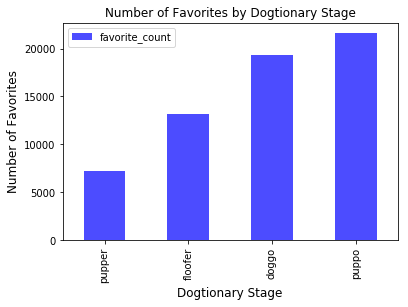

In [49]:
# Gather the rows that have values in the dogtionary_stage column
df_with_stages = twitter_archive_master[twitter_archive_master['dogtionary_stage'].isnull()==False]

# Gather the rows that only have the value "doggo", "floofer", "pupper", or 
# "puppo"
df_stages = df_with_stages.query('dogtionary_stage=="doggo" or \
                                  dogtionary_stage=="floofer" or \
                                  dogtionary_stage=="pupper" or \
                                  dogtionary_stage=="puppo"')

# Find the favorite count grouped by each of the four stages
fav_counts = pd.DataFrame(df_stages.groupby('dogtionary_stage').favorite_count.mean().sort_values())
fav_counts['dogtionary_stage'] = fav_counts.index

fav_counts.plot(x='dogtionary_stage', y='favorite_count', kind='bar', 
                color='blue', alpha=0.7);
plt.title('Number of Favorites by Dogtionary Stage');
plt.xlabel('Dogtionary Stage', fontsize=12);
plt.ylabel('Number of Favorites', fontsize=12);

> This analysis and visualization utilized the following cleaned data:
- The combination of the `doggo`, `floofer`, `pupper`, and `puppo` stages allows for querying a single column for certain values. 
- The merging of the column `favorite_count` with the main archive table allows for finding the combined favorite count for each of the four stages. 

### Question 2
Which stage of the dogs in this dataset gets the most retweets?
**<a href="#insights">Insight</a>**

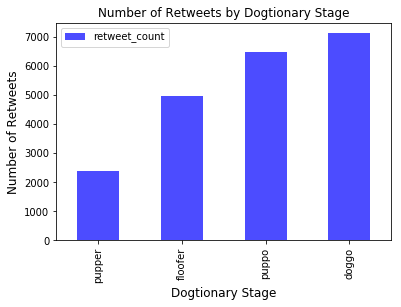

In [50]:
# Find the favorite count grouped by each of the four stages
rt_counts = pd.DataFrame(df_stages.groupby('dogtionary_stage').retweet_count.mean().sort_values())

rt_counts['dogtionary_stage'] = rt_counts.index

rt_counts.plot(x='dogtionary_stage', y='retweet_count', kind='bar', 
               color='blue', alpha=0.7);
plt.title('Number of Retweets by Dogtionary Stage');
plt.xlabel('Dogtionary Stage', fontsize=12);
plt.ylabel('Number of Retweets', fontsize=12);

> This analysis and visualization utilized the following cleaned data:
- The combination of the `doggo`, `floofer`, `pupper`, and `puppo` stages allows for querying a single column for certain values. 
- The merging of the column `retweet_count` with the main archive table allows for finding the combined favorite count for each of the four stages. 

### Question 3
Is there a correlation between favorites and retweets?
**<a href="#insights">Insight</a>**

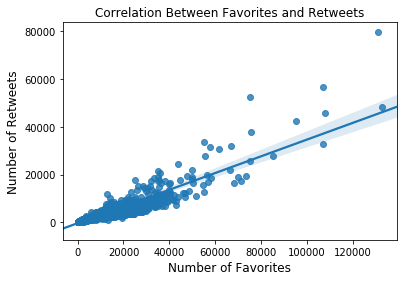

In [52]:
sns.regplot(twitter_archive_master['favorite_count'], twitter_archive_master['retweet_count'])
plt.title('Correlation Between Favorites and Retweets');
plt.xlabel('Number of Favorites', fontsize=12);
plt.ylabel('Number of Retweets', fontsize=12);

> This analysis and visualization utilized the following cleaned data:
- The merging of the columns `favorite_count` and `retweet_count` with the main archive table allows for creating a visualization depicting whether or not there is a correlation between the two sets of values. 

<a id='insights'></a>
### Insights:
1. The stage `puppo` gets the most favorites. 

2. The stage `doggo` gets the most retweets.

3. There is a strong and positive relationship between `retweet_count` and `favorite_count`.